In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from copy import deepcopy
from dataclasses import dataclass
from typing import Union

book_path = "../data/book.csv"
trades_path = "../data/trades.csv"
ticker_path = "../data/ticker.csv"

def preprocess_data(path):
    df = pd.read_csv(path)
    df.rename(columns={"remote_ts": "exchange_ts"}, inplace=True)
    df.drop(columns=["remote_ts2", "seq", "local_ts"], inplace=True)
    df.sort_values(by=["exchange_ts"], inplace=True)
    return df

original_ticker = preprocess_data(ticker_path)
original_trades = preprocess_data(trades_path)

def get_in_time(df, min_ts, max_ts):
    res = df[(df["exchange_ts"] >= min_ts) & (df["exchange_ts"] <= max_ts)]
    res = res.reset_index(drop=True)
    return res


In [2]:
class Heap:    
    def __init__(self, comp = lambda x, y: x < y):
        self.a = [-1]
        self.id = {}
        self.ptr = {}
        self.comp = comp

    def exchange(self, v: int, u: int):
        self.id[v], self.id[u] = self.id[u], self.id[v]
        self.ptr[self.id[v]], self.ptr[self.id[u]] = self.ptr[self.id[u]], self.ptr[self.id[v]]
        self.a[v], self.a[u] = self.a[u], self.a[v]

    def sift_up(self, v: int):
        while v > 1 and self.comp(self.a[v], self.a[v // 2]):
            self.exchange(v, v // 2)
            v //= 2
    
    def sift_down(self, v: int):
        while 2 * v <= len(self.a) - 1:
            u = 2 * v
            if u + 1 <= len(self.a) - 1 and self.comp(self.a[u + 1], self.a[u]):
                u += 1
            if not self.comp(self.a[u], self.a[v]):
                break
            self.exchange(v, u)
            v = u
    
    def push(self, x, id: int):
        self.a.append(x)
        self.id[len(self.a) - 1] = id
        self.ptr[id] = len(self.a) - 1
        self.sift_up(len(self.a) - 1)

    def extract_min(self):
        return self.extract_by_id(self.id[1])

    def get_min(self):
        return self.a[1]
    
    def get_by_id(self, id: int):
        return self.a[self.ptr[id]]
    
    def extract_by_id(self, id: int):
        v = self.ptr[id]
        self.exchange(v, len(self.a) - 1)
        self.ptr[self.id[len(self.a) - 1]] = -1
        v = self.a.pop()
        self.sift_down(1)
        return v
    
    def __bool__(self):
        return len(self.a) > 1

In [3]:
@dataclass
class MdUpdate:
    exchange_ts: int
    receive_ts: int
    best_bid: float
    best_ask: float
    bid_amount: float
    ask_amount: float


@dataclass
class Order:
    send_ts: int
    exchange_ts: int
    is_bid: bool
    amount: float
    price: float 
    id: int 


@dataclass
class ExecutedTrade:
    receive_ts: int
    is_buy: bool
    amount: float
    price: float

@dataclass
class MarketTrade:
    exchange_ts: int
    is_buy: bool
    amount: float
    price: float

    
@dataclass
class EventItem:
    type: str 
    object: Union[Order, MdUpdate]
    ts: int
    

In [7]:
min_ts_test = pd.Timestamp("2023-03-23 04:00:00").value // 1000000 # time in milliseconds
max_ts_test = pd.Timestamp("2023-03-23 07:59:59").value // 1000000

test_ticker = get_in_time(original_ticker, min_ts_test, max_ts_test)
test_trades = get_in_time(original_trades, min_ts_test, max_ts_test)

In [50]:
class ExchangeSimulator:

    '''
    Class simulating the process of order execution on an exchange using market data and trading rules.
    It interacts with strategy listeners based on the market events, making it possible to test 
    trading strategies against historical market data.

    run: Drives the main simulation loop, processing events, and interacting with the strategy listener 
    to make trading decisions.

    _add_event_to_heap: Adds a new event to the priority queue of events, which will be processed based 
    on their timestamps.

    _get_next_event_from_heap: Retrieves and removes the next event from the queue based on its timestamp.

    _notify_listener_and_get_order: Notifies the associated strategy listener of a market event and 
    retrieves any resultant trading orders.

    _handle_order_request: Processes an incoming order, adding it to the corresponding order book based on 
    its type (bid or ask).

    _handle_market_trade: Simulates the execution of trades in the market based on order book status and 
    incoming trades.

    _process_active_orders: Cleans up expired orders and executes matchable orders from the order book.

    _delete_old_orders: Removes orders from the system that have expired beyond the specified latency.

    _execute_orders: Matches and executes available orders in the order book based on prevailing market prices.

    _place_order: Introduces a new order into the simulator, adjusting its timestamp for execution latency.

    _process_market_data: Ingests historical market data, converting it into a sequence of market update 
    and trade events for the simulation.

    _update_best_bid_ask: Updates the prevailing best bid and ask prices based on the most recent market data update.
    '''

    def __init__(self, ticker, trades, exec_latency, updates_latency, delete_latency, listener):
        self.exec_latency, self.updates_latency = exec_latency, updates_latency
        self.current_exchange_ts, self.delete_latency = 0, delete_latency 
        self.best_bid, self.best_ask = -np.inf, np.inf
        
        self.events = Heap(comp=lambda x, y: x.ts < y.ts)
        self.active_orders_bid = Heap(comp=lambda x, y: (-x.price, x.exchange_ts) < (-y.price, y.exchange_ts))
        self.active_orders_ask = Heap(comp=lambda x, y: (x.price, x.exchange_ts) < (y.price, y.exchange_ts))
        self.all_orders = Heap(comp=lambda x, y: x.exchange_ts < y.exchange_ts)

        self.order_id, self.event_id = 0, 0
        self.listener = listener

        self._process_market_data(ticker, trades)

    def _add_event_to_heap(self, event_type, event_object, ts):
        self.event_id += 1
        self.events.push(EventItem(event_type, event_object, ts), self.event_id)

    def _get_next_event_from_heap(self):
        return self.events.extract_min()

    def run(self):
        while self.events:
            self._process_active_orders()
            event = self._get_next_event_from_heap()

            if event.type == "MdUpdate":
                self.current_exchange_ts = event.object.exchange_ts
                self._update_best_bid_ask(event.object)
            elif event.type == "OrderRequest":
                self.current_exchange_ts = event.object.exchange_ts
                self._handle_order_request(event.object)
            elif event.type == "MarketTrade":
                self.current_exchange_ts = event.object.exchange_ts
                self._handle_market_trade(event.object)
                
            elif event.type in ["StrategyMdUpdate", "StrategyExecutedTrade"]:
                orders = self._notify_listener_and_get_order(event.type, event.object, event.ts)
                for order in orders:
                    self._place_order(order)

    def _notify_listener_and_get_order(self, event_type, event_object, event_ts):
        orders = []
        response = self.listener._on_event(event_type, event_object, event_ts)
        if response:
            orders.extend(response)
        return orders

    def _handle_order_request(self, order):
        heap = self.active_orders_bid if order.is_bid else self.active_orders_ask
        heap.push(order, order.id)
        self.all_orders.push(order, order.id)

    def _handle_market_trade(self, trade):
        heap = self.active_orders_ask if trade.is_buy else self.active_orders_bid
        comp = lambda x, y: x <= y if trade.is_buy else x >= y
        best_price = self.best_ask if trade.is_buy else self.best_bid
        while heap and trade.amount > 0 and comp(heap.get_min().price, trade.price) and comp(heap.get_min().price, best_price):
            order = heap.get_min()
            trade_amount = min(order.amount, trade.amount)
            trade.amount -= trade_amount
            order.amount -= trade_amount
            executed_trade = ExecutedTrade(self.current_exchange_ts + self.updates_latency,
                                           is_buy=not trade.is_buy, price=order.price, amount=trade_amount)

           
            self._add_event_to_heap("StrategyExecutedTrade", executed_trade, executed_trade.receive_ts)
            if order.amount == 0:
                heap.extract_min()
                self.all_orders.extract_by_id(order.id)

    def _process_active_orders(self):
        self._delete_old_orders()
        self._execute_orders(False)
        self._execute_orders(True)

    def _delete_old_orders(self):
        while self.all_orders:
            order = self.all_orders.get_min()
            if order.exchange_ts + self.delete_latency <= self.current_exchange_ts:
                heap = self.active_orders_bid if order.is_bid else self.active_orders_ask
                heap.extract_by_id(order.id)
                self.all_orders.extract_min()
            else:
                break

    def _execute_orders(self, is_bid):
        heap = self.active_orders_bid if is_bid else self.active_orders_ask
        best_price = self.best_ask if is_bid else self.best_bid
        comp = lambda x, y: x >= y if is_bid else x <= y
        while heap and comp(heap.get_min().price, best_price):
            order = heap.extract_min()
            self.all_orders.extract_by_id(order.id)
            executed_trade = ExecutedTrade(self.current_exchange_ts + self.updates_latency,
                                           is_buy=is_bid, price=order.price, amount=order.amount)

            self._add_event_to_heap("StrategyExecutedTrade", executed_trade, executed_trade.receive_ts)

    def _place_order(self, order):
        order_copy = deepcopy(order)
        order_copy.exchange_ts = order.send_ts + self.exec_latency
        if order_copy.exchange_ts <= max_ts_test:
            self.order_id += 1
            order_copy.id = self.order_id
            self._add_event_to_heap("OrderRequest", order_copy, order_copy.exchange_ts)

    def _process_market_data(self, ticker, trades):
            
        market_data = ticker.apply(lambda x: MdUpdate(
            exchange_ts=int(x["exchange_ts"]),
            receive_ts=int(x['exchange_ts'] + self.updates_latency),
            best_bid=float(x["bid_price"]),
            best_ask=float(x["ask_price"]),
            bid_amount=float(x["bid_amount"]),
            ask_amount=float(x["ask_amount"]),
        ), axis=1).tolist()
        
        for md_update in market_data:
            self._add_event_to_heap("MdUpdate", md_update, md_update.exchange_ts)
            st_md_update = deepcopy(md_update)
            self._add_event_to_heap("StrategyMdUpdate", st_md_update, md_update.exchange_ts + self.updates_latency)

        market_trades = trades.apply(lambda x: MarketTrade(
            exchange_ts=int(x["exchange_ts"]),
            is_buy=(x["side"] == "B"),
            price=float(x["price"]),
            amount=float(x["amount"]),
        ), axis=1).tolist()
        

        for trade in market_trades:
            self._add_event_to_heap("MarketTrade", trade, trade.exchange_ts) 


    def _update_best_bid_ask(self, md):
        self.best_bid, self.best_ask = md.best_bid, md.best_ask

In [51]:
class StoikovStrategy:

    '''
    Class implementing the Stoikov trading strategy for order placement and execution in a financial market.

    get_stats: Returns a DataFrame summarizing the strategy's market interactions, positions, balances, and trades.

    _calculate_order_price: Calculates the price of an order based on the strategy's parameters and market conditions.

    _handle_market_update: Updates the strategy's internal state based on market data updates.

    _handle_trade_execution: Handles trade execution events, updating strategy variables.

    _on_event: Handles incoming events from the market, such as market data updates and trade executions.

    _check_and_place_orders: Checks conditions and places orders based on strategy rules and market conditions.

    _update_stats: Updates internal statistical records with relevant market data and strategy state.
    '''
    def __init__(self, gamma, k, sigma, adjust_latency, order_amount, pos_normilizer):
        self.gamma, self.k, self.sigma = gamma, k, sigma
        self.remaining_time = 1.0
        self.order_amount, self.pos_normilizer = order_amount, pos_normilizer
        self.current_position, self.current_balance, self.best_ask, self.best_bid = 0.0, 0.0, np.inf, -np.inf
        self.current_ts, self.prev_order_ts, self.adjust_latency = 0, 0, adjust_latency

        self.market_price_list, self.ts_list, self.trades_list = [], [], []
        self.bid_list, self.ask_list = [], []
        self.position_list, self.balance_list = [], []

    def _calculate_order_price(self, is_bid):
        spread = self.gamma * self.sigma**2 * self.remaining_time + 2 / self.gamma * np.log(1 + self.gamma / self.k)
        mid_price = (self.best_bid + self.best_ask) / 2
        indiff_price = mid_price - self.current_position * self.pos_normilizer * self.gamma * self.sigma**2 * self.remaining_time
        return round(indiff_price - spread / 2 if is_bid else indiff_price + spread / 2, 1)

    def _handle_market_update(self, md_update):
        self.best_bid, self.best_ask = md_update.best_bid, md_update.best_ask
        self._update_stats(md_update)

    def _handle_trade_execution(self, trade):
        self.current_position += trade.amount if trade.is_buy else -trade.amount
        self.current_balance += -trade.amount * trade.price if trade.is_buy else trade.amount * trade.price
        self.trades_list.append(trade)

    def _on_event(self, event_type, event_object, event_ts):
            self.current_ts = event_ts
            self.remaining_time = (max_ts_test - self.current_ts) / (max_ts_test - min_ts_test)
            if event_type == "StrategyMdUpdate":
                self._handle_market_update(event_object)
            elif event_type == "StrategyExecutedTrade":
                self._handle_trade_execution(event_object)
            return self._check_and_place_orders()

    def _check_and_place_orders(self):
        if self.current_ts - self.prev_order_ts > self.adjust_latency:
            self.prev_order_ts = self.current_ts
            return [Order(send_ts=self.current_ts, amount=self.order_amount, price=self._calculate_order_price(is_bid), is_bid=is_bid, exchange_ts=-1, id=-1)
                    for is_bid in (True, False)]

    def _update_stats(self, md_update):
        self.market_price_list.append((self.best_ask + self.best_bid) / 2)
        self.ts_list.append(md_update.receive_ts)
        self.ask_list.append(self._calculate_order_price(False))
        self.bid_list.append(self._calculate_order_price(True))
        self.position_list.append(self.current_position)
        self.balance_list.append(self.current_balance + self.current_position * self.market_price_list[-1])

    def get_stats(self):
        return {
            "market_price": self.market_price_list,
            "ts": self.ts_list,
            "bid": self.bid_list,
            "ask": self.ask_list,
            "position": self.position_list,
            "balance": self.balance_list,
            "trades": self.trades_list
        }

In [52]:
strategy = StoikovStrategy(gamma=0.001, k=1, sigma=20, adjust_latency=100, order_amount=0.1, pos_normilizer=10)
exchange_simulator = ExchangeSimulator(ticker=test_ticker, trades=test_trades,
                                       exec_latency=5, updates_latency=5, delete_latency=100, listener=strategy)

exchange_simulator.run()
stats = strategy.get_stats()

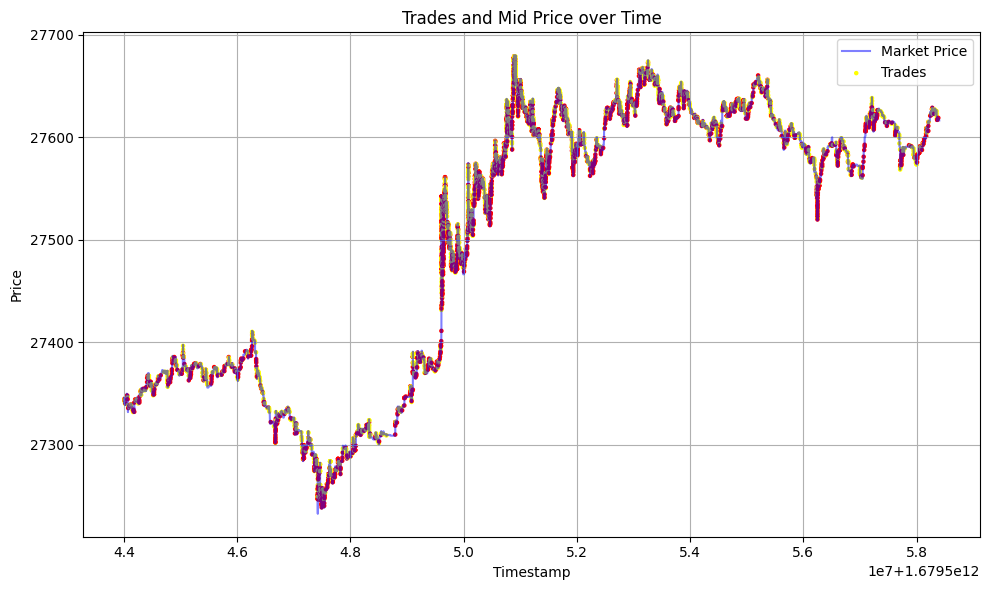

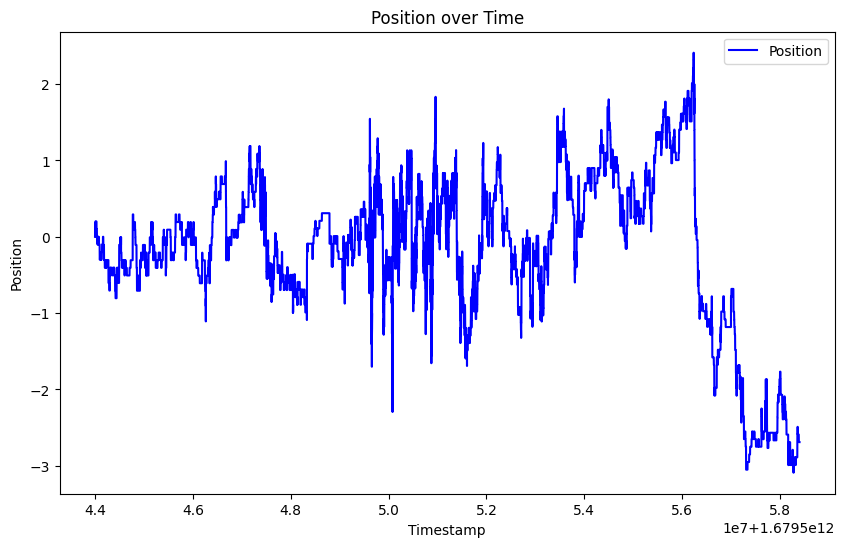

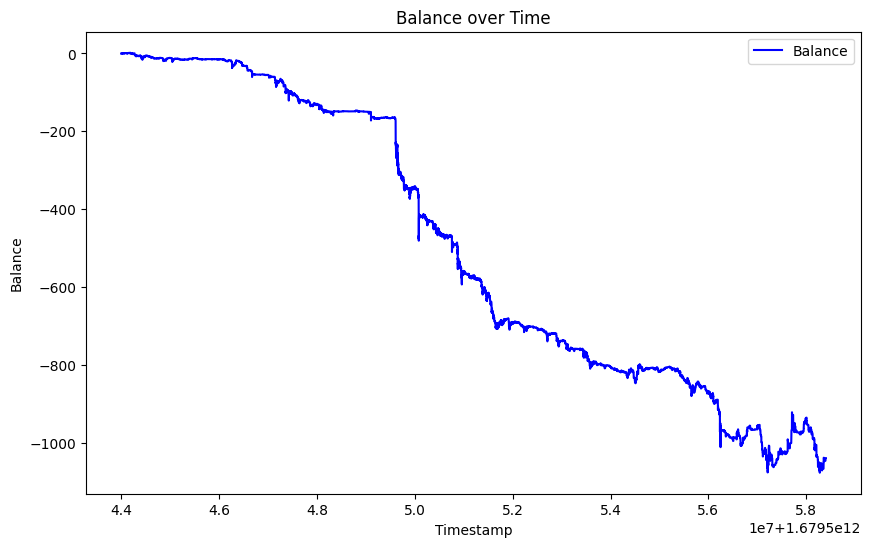

In [53]:
def plot_stats(stats):
    market_price_list = stats["market_price"]
    ts_list = stats["ts"]
    trades_list = stats["trades"]
    position_list = stats["position"]
    balance_list = stats["balance"]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ts_list, market_price_list, label="Market Price", color='blue', alpha=0.5)
    trade_tss = [trade.receive_ts for trade in trades_list]
    trade_prices = [trade.price for trade in trades_list]
    trade_colors = ['yellow' if trade.is_buy else 'red' for trade in trades_list]
    ax.scatter(trade_tss, trade_prices, label="Trades", color=trade_colors, alpha=1, s=5)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Price')
    ax.set_title('Trades and Mid Price over Time')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ts_list, position_list, label="Position", color='blue')
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Position")
    ax.set_title("Position over Time")
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ts_list, balance_list, label="Balance", color='blue')
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Balance")
    ax.set_title("Balance over Time")
    ax.legend()
    plt.show()

plot_stats(stats)

**Next comes the preparation of data for the improved strategy and the strategy itself**

In [54]:
min_ts_train = pd.Timestamp("2023-03-23 00:00:00").value // 1000000
max_ts_train = pd.Timestamp("2023-03-23 03:59:59").value // 1000000

train_ticker = get_in_time(original_ticker, min_ts_train, max_ts_train)
train_trades = get_in_time(original_trades, min_ts_train, max_ts_train)


In [55]:
delta_ts = 100
def custom_grouper(exchange_ts, delta=delta_ts):
    start_ts = exchange_ts.iloc[0]
    group = []
    
    for ts in exchange_ts:
        if ts - start_ts <= delta:
            group.append(start_ts)
        else:
            start_ts = ts
            group.append(start_ts)
    return group


def group_ticker_by_ts(df, delta):
    df['group'] = custom_grouper(df['exchange_ts'], delta)
    result = df.groupby('group').agg(bid_price=('bid_price', 'mean'), ask_price=('ask_price', 'mean'), 
                                     bid_amount=('bid_amount', 'sum'), ask_amount=('ask_amount', 'sum'),
                                     exchange_ts=('exchange_ts', 'first'))
    return result


train_ticker = group_ticker_by_ts(train_ticker, delta=delta_ts)
train_ticker = train_ticker.reset_index(drop=True)

train_ticker['ask_price'] = round(train_ticker['ask_price'], 1)
train_ticker['bid_price'] = round(train_ticker['bid_price'], 1)

train_ticker['imbalance'] = (train_ticker['bid_amount'] - train_ticker['ask_amount']) / (train_ticker['bid_amount'] + train_ticker['ask_amount'])
train_ticker['spread'] = train_ticker['ask_price'] - train_ticker['bid_price']
train_ticker['mid_price'] = (train_ticker['ask_price'] + train_ticker['bid_price']) / 2
train_ticker['mid_price'] = round(train_ticker['mid_price'], 1)

In [56]:
n_z = 5  # for volume imbalance
n_delta = 10  # for bid-ask spread

range_z = range(-(n_z // 2), n_z // 2 + 1)
range_delta = range(1, n_delta + 1) 

train_ticker['z'] = np.round(train_ticker['imbalance'] * n_z / 2, 0).astype(int)
train_ticker['delta'] = np.ceil(train_ticker['spread'] * 10).astype(int)
train_ticker = train_ticker[(train_ticker['delta'] <= n_delta) & (train_ticker['delta'] >= 1)] # remove outliers
train_ticker.reset_index(drop=True, inplace=True)

total_time = {(z, delta): sum((train_ticker['z'] == z) & (train_ticker['delta'] == delta)) for z in range_z for delta in range_delta}


In [57]:
def get_nearest(arr, x):
    l = 0
    r = len(arr) - 1
    while r - l > 1:
        m = (l + r) // 2
        if arr[m] > x:
            r = m
        else:
            l = m
    return l

def get_price(exchange_ts):
    pos = get_nearest(train_ticker['exchange_ts'], exchange_ts)
    return train_ticker['mid_price'][pos]

def get_imbalance_and_spread(exchange_ts):
    pos = get_nearest(train_ticker['exchange_ts'], exchange_ts)
    return train_ticker["imbalance"][pos], train_ticker["spread"][pos]

def get_z_delta(exchange_ts):
    pos = get_nearest(train_ticker['exchange_ts'], exchange_ts)
    return train_ticker["z"][pos], train_ticker["delta"][pos]



In [58]:
data = {'buy': {
            (z, delta): {'cnt': 0, 'price_change_sum': 0} for z in range_z for delta in range_delta},
        'sell': {
            (z, delta): {'cnt': 0, 'price_change_sum': 0} for z in range_z for delta in range_delta}
        }

for _, row in train_trades.iterrows():
    side = 'buy' if row['side'] == 'B' else 'sell'
    
    pos = get_nearest(train_ticker['exchange_ts'], row['exchange_ts'])

    if train_ticker.iloc[pos + 1]['exchange_ts'] - row['exchange_ts'] > delta_ts:
        continue
    
    z, delta = get_z_delta(row['exchange_ts'])
    data[side][(z, delta)]['cnt'] += 1
    data[side][(z, delta)]['price_change_sum'] += (train_ticker.iloc[pos + 1]['mid_price'] - train_ticker.iloc[pos]['mid_price'])


In [59]:
decision_metric = {
    'buy': {},
    'sell': {}
}

for z in range_z:
    for delta in range_delta:
        if data['buy'][(z, delta)]['cnt'] + data['sell'][(- z, delta)]['cnt'] != 0:
            decision_metric['buy'][(z, delta)] = ((data['buy'][(z, delta)]['price_change_sum'] + data['sell'][(-z, delta)]['price_change_sum']) / 
                                          (data['buy'][(z, delta)]['cnt'] + data['sell'][(- z, delta)]['cnt']))
            
        if data['sell'][(z, delta)]['cnt'] + data['buy'][(-z, delta)]['cnt'] != 0:
            decision_metric['sell'][(z, delta)] = ((data['sell'][(z, delta)]['price_change_sum'] + data['buy'][(-z, delta)]['price_change_sum']) / 
                                          (data['sell'][(z, delta)]['cnt'] + data['buy'][(- z, delta)]['cnt']))
        


In [60]:
class StoikovImbalanceStrategy(StoikovStrategy):

    def __init__(self, gamma, k, sigma, adjust_latency, order_amount, pos_normilizer):
        super().__init__(gamma, k, sigma, adjust_latency, order_amount, pos_normilizer)
        self.imbalance = 0
        self.spread = 0
        self.best_bid_amount = 0
        self.best_ask_amount = 0
    

    def _handle_market_update(self, md_update):
        self.best_bid, self.best_ask = md_update.best_bid, md_update.best_ask
        self.best_bid_amount, self.best_ask_amount = md_update.bid_amount, md_update.ask_amount
        self.imbalance = (self.best_bid_amount - self.best_ask_amount) / (self.best_bid_amount + self.best_ask_amount)
        self.spread = self.best_ask - self.best_bid
        self._update_stats(md_update)

    def _check_and_place_orders(self):
        if self.current_ts - self.prev_order_ts > self.adjust_latency:
            self.prev_order_ts = self.current_ts

            z = round(self.imbalance * n_z / 2, ndigits=None)
            delta = math.ceil(self.spread * 10)

            orders = []
            if (z, delta) in decision_metric['buy'] and delta / 2 - decision_metric['buy'][(z, delta)] > 0:
                self.prev_order_ts = self.current_ts
                orders.append(Order(send_ts=self.current_ts, amount=self.order_amount, price=self._calculate_order_price(True), is_bid=True, exchange_ts=-1, id=-1))
            if (z, delta) in decision_metric['sell'] and delta / 2 - decision_metric['sell'][(z, delta)] > 0:
                self.prev_order_ts = self.current_ts
                orders.append(Order(send_ts=self.current_ts, amount=self.order_amount, price=self._calculate_order_price(False), is_bid=False, exchange_ts=-1, id=-1))

            return orders


In [63]:
strategy = StoikovImbalanceStrategy(gamma=0.001, k=1, sigma=20, adjust_latency=100, order_amount=0.1, pos_normilizer=10)
exchange_simulator = ExchangeSimulator(ticker=test_ticker, trades=test_trades,
                                       exec_latency=5, updates_latency=5, delete_latency=100, listener=strategy)

exchange_simulator.run()
stats = strategy.get_stats()

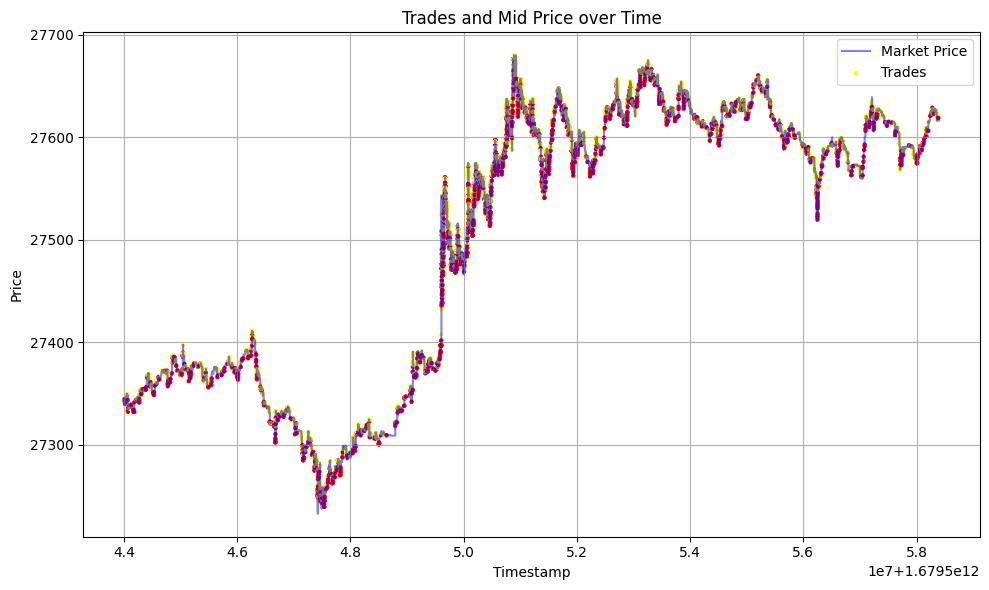

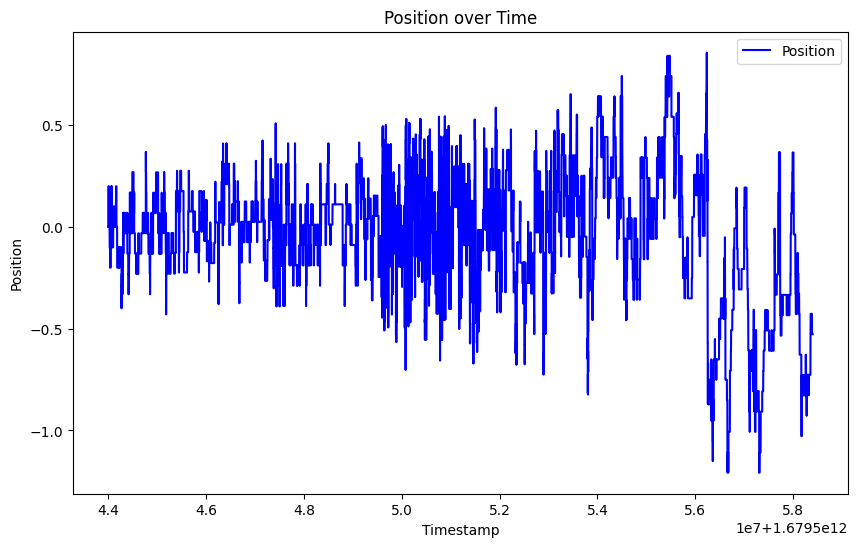

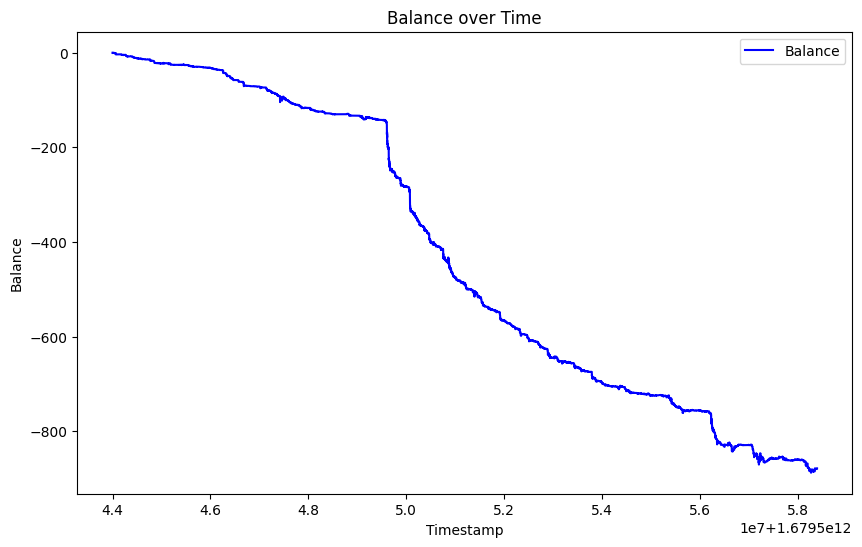

In [64]:
plot_stats(stats)